In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

import sys

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import EllipseCollection
from matplotlib import rcParams
from matplotlib import cm
from netCDF4 import num2date

from PyFVCOM.read_FVCOM_results import ncread
from PyFVCOM.tidal_ellipse import ap2ep
from tappy import TAPPY

In [3]:
# Load model output.
fvcom = 'sample.nc'

varlist = ('lonc', 'latc', 'ua', 'va', 'time')
dims = {'time': ':360'}  # first 15 days at hourly sampling

# Define a plot subset ((xmin, xmax), (ymin, ymax)).
subset = np.array(((-4.2416, -4.0837), (50.2656, 50.3966)))

# Scaling factor for the ellipses. You will need to experiment with this
# value.
scaling = 2000

# Find the model nodes which fall within the subset defined above.
FVCOM = ncread(fvcom, vars=varlist, dims=dims, noisy=False)

In [4]:
# Create a time array for the TAPPy call.
FVCOM['datetimes'] = num2date(FVCOM['time'], 'days since 1858-11-17 00:00:00')
years = [i.year for i in FVCOM['datetimes']]
months = [i.month for i in FVCOM['datetimes']]
days = [i.day for i in FVCOM['datetimes']]
hours = [i.hour for i in FVCOM['datetimes']]
minutes = [i.minute for i in FVCOM['datetimes']]
seconds = [i.second for i in FVCOM['datetimes']]
Times = np.column_stack((years, months, days, hours, minutes, seconds))

In [5]:
# Find the indices of the locations which fall within the subset.
elems = np.where((FVCOM['lonc'] > subset[0].min()) *
                 (FVCOM['lonc'] < subset[0].max()) *
                 (FVCOM['latc'] > subset[1].min()) *
                 (FVCOM['latc'] < subset[1].max()))[0]

In [6]:
# Create dicts for the results.
uharmonics, vharmonics = {}, {}

# Loop over the indices within the region of interest. This will take a 
# while in serial. Implementing this in parallel is left as an exercise
# for the reader!
for i, idx in enumerate(elems):
    
    if i == 0:
        print('{} of {} '.format(i + 1, len(elems)), end='')
    elif (i + 1) % 100 == 0:
        print('\n{} of {} '.format(i + 1, len(elems)), end='')
    elif i + 1 == len(elems):
        print(' done.')
    else:
        print('.', end='')
    sys.stdout.flush()

    # Combine the Times and velocity data.
    u = np.column_stack((Times, FVCOM['ua'][:, idx]))
    v = np.column_stack((Times, FVCOM['va'][:, idx]))

    # Create a dict for the TAPPy results.
    uharm, vharm = {}, {}
    uharm['name'], uharm['speed'], uharm['phase'], uharm['amp'], uharm['infer'] = TAPPY(u)
    vharm['name'], vharm['speed'], vharm['phase'], vharm['amp'], vharm['infer'] = TAPPY(v)

    # Put the results into a meta dict with the key being the current
    # position.
    key = '{}-{}'.format(FVCOM['lonc'][idx], FVCOM['latc'][idx])
    uharmonics[key] = uharm
    vharmonics[key] = vharm

1 of 1235 ..................................................................................................
100 of 1235 ...................................................................................................
200 of 1235 ...................................................................................................
300 of 1235 ...................................................................................................
400 of 1235 ...................................................................................................
500 of 1235 ...................................................................................................
600 of 1235 ...................................................................................................
700 of 1235 ...................................................................................................
800 of 1235 ...............................................................................................

In [7]:
# Create the mapping object ready for the plot.
m = Basemap(llcrnrlon=subset[0].min(),
            llcrnrlat=subset[1].min(),
            urcrnrlon=subset[0].max(),
            urcrnrlat=subset[1].max(),
            rsphere=(6378137.00, 6356752.3142),
            resolution='f',
            area_thresh=0.05,
            projection='merc',
            lat_0=subset[1].mean(),
            lon_0=subset[0].mean(),
            lat_ts=subset[0].mean())

parallels = np.arange(np.floor(subset[1].min()),
                      np.ceil(subset[1].max()), 0.025)
meridians = np.arange(np.floor(subset[0].min()),
                      np.ceil(subset[0].max()), 0.05)

x, y = m(FVCOM['lonc'], FVCOM['latc'])

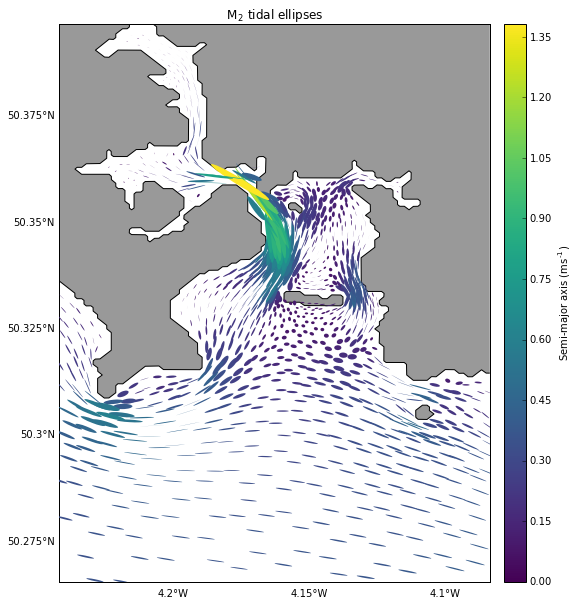

In [8]:
# Extract all the ellipses for the current subset so we can plot them 
# more easily.

xy = []
widths = []
heights = []
rotations = []
sema = []
for em in elems:
    # Make a key from the original positions. This is the key which we
    # use to extract the harmonic results.
    key = '{}-{}'.format(FVCOM['lonc'][em], FVCOM['latc'][em])
    
    # Find the M2 data position for the current position.
    idx = uharmonics[key]['name'].index('M2')
    
    # Extract the amplitude and phase and calculate the ellipse 
    # properties.
    uZ = uharmonics[key]['amp'][idx]
    vZ = vharmonics[key]['amp'][idx]
    uG = uharmonics[key]['phase'][idx]
    vG = vharmonics[key]['phase'][idx]
    SEMA, ECC, INC, PHA, w = ap2ep(uZ, uG, vZ, vG)

    xy.append((x[em], y[em]))
    # widths and heights are flipped so the rotation is effectively
    # transformed from clockwise from the y-axis to anti-clockwise 
    # relative to the x-axis. This is what EllipseCollection needs
    # for its angles.
    widths.append(scaling * SEMA)
    heights.append(scaling * SEMA * ECC)
    rotations.append(INC)
    # Save the semi-major axis for the colouring the ellipses.
    sema.append(SEMA)
      
# Now plot the M2 results.
rcParams['mathtext.default'] = 'regular'  # sensible font for LaTeX text

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')

# Make an EllipseCollection.
ellipses = EllipseCollection(widths, heights, rotations, 
                             offsets=xy,
                             units='xy',
                             transOffset=ax.transData)
ellipses.set_array(np.asarray(sema))

# Add coastlines
m.drawmapboundary(zorder=0)
m.drawcoastlines(zorder=1)
m.fillcontinents(zorder=0, color='0.6')
m.drawparallels(parallels, labels=[1, 0, 0, 0], linewidth=0)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], linewidth=0)

# Add ellipses coloured by the semi-major axis magnitude.
ax.add_collection(ellipses)
ellipses.set_linewidth(0)
ellipses.set_cmap(cm.viridis)
ellipses.set_zorder=200
    
# Add a nice colour bar.
div = make_axes_locatable(ax)
cax = div.append_axes("right", size="5%", pad=0.2)
cb = fig.colorbar(ellipses, cax=cax)
cb.set_label("Semi-major axis ($ms^{-1}$)")

ax.set_title('$M_2$ tidal ellipses')